In [1]:
# 사용할 모듈 불러오기 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re


In [2]:
# 데이터 불러오기
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")
item_categories = pd.read_csv('./data/item_categories.csv')

# EDA

## Train
###  columns 뜻
 - data  = 날짜
 - date_block_num  = 한달 단위로 구분하기 편하게 하기 위한 데이터
 - shop_id = 가게 id
 - item_price = 아이템 가격
 - item_cnt_day = 당일 해당 아이템이 팔린 개수

In [3]:
train.info() # null 값이 모든데이터에 존재 하지 않는다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [4]:
#  date의 자료형을 object  -> dattime 으로 바꾸고 싶다. 
# 변환하는 과정  ->
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")
train["date"]. head(3) 

0   2013-01-02
1   2013-01-03
2   2013-01-05
Name: date, dtype: datetime64[ns]

In [5]:
train.describe(include = 'all')

/var/folders/n4/tlr0x9b97v3bzyh49yfs3ps00000gn/T/ipykernel_1010/2740853986.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train.describe(include = 'all')


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
unique,1034,NaN,NaN,NaN,NaN,NaN
top,2013-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN
freq,9434,NaN,NaN,NaN,NaN,NaN
first,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2015-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,NaN,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,NaN,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00


2013-01-01 00:00:00 ~ 2015-10-31 00:00:00  까지의 1034일간의 데이터임을 알수있다.  
item_price은 평균과 중위값의 차이가 심한 것으로 보아 이상치가 존재함을 알 수 있디.  
item_cnt_day 는일,이,삼 분위수가 1인데 비해 평균은 대략 1.2  최대값은 2168로 이상치가 존재한다.   
item_cnt_day, item_price에 최소값들은 음수이다.  

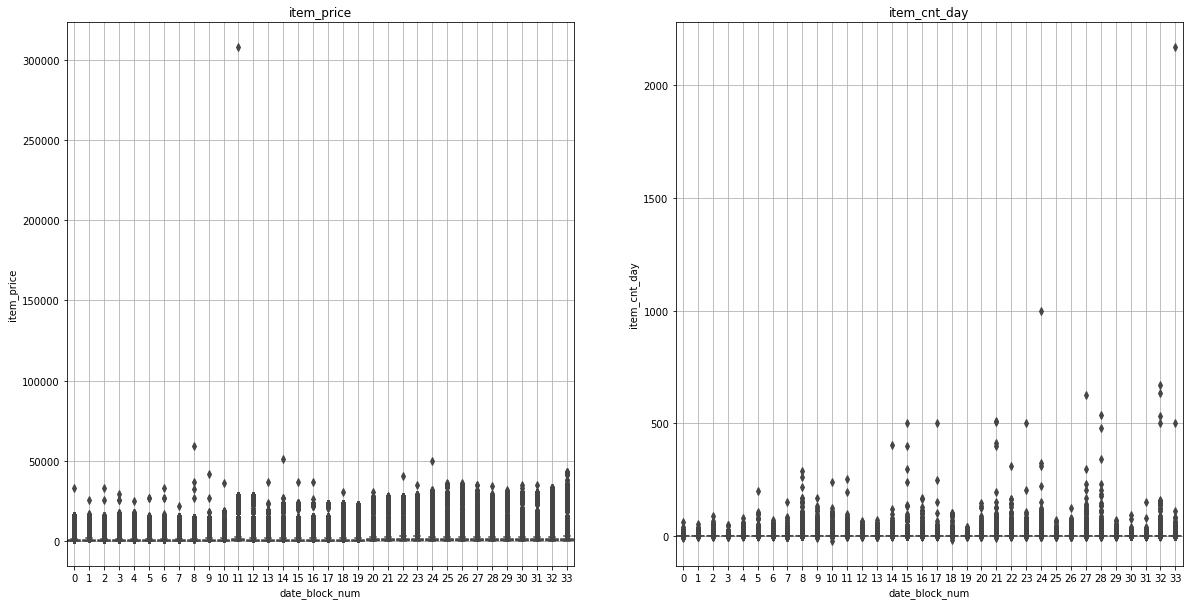

In [6]:
def price_item_cnt_day_boxplot():
    plt.figure(figsize = (20,10))
    # item_price 의 박스플롯
    plt.subplot(1,2,1)
    sns.boxplot(x = 'date_block_num' , y= 'item_price',data =train)
    plt.title('item_price')
    plt.grid()
    # item_cnt_day의 박스 플롯
    plt.subplot(1,2,2)
    sns.boxplot(x = 'date_block_num' , y= 'item_cnt_day',data =train)
    plt.title('item_cnt_day')
    plt.grid()
price_item_cnt_day_boxplot()

- 다음은 date_block_num 별로 item_price의 boxplot이다.  
- 위의 그래프를 기준으로 item_price는 50000 이상 , item_cnt_day 는 1000 이상을 이상치로서 train에서 제거한다.  
- 또한 판매되는 수량을 구하는 것이 목적이므로 0미만의 값을 제거한다.

In [7]:
condition_for_drop = ((train["item_price"] >= 50000) | (train["item_price"] < 0))
train.drop(train[condition_for_drop].index, axis = 0 , inplace=True)

condition_for_drop = ((train["item_cnt_day"] >= 1000) | (train["item_cnt_day"] < 0))
train.drop(train[condition_for_drop].index, axis = 0 , inplace=True)

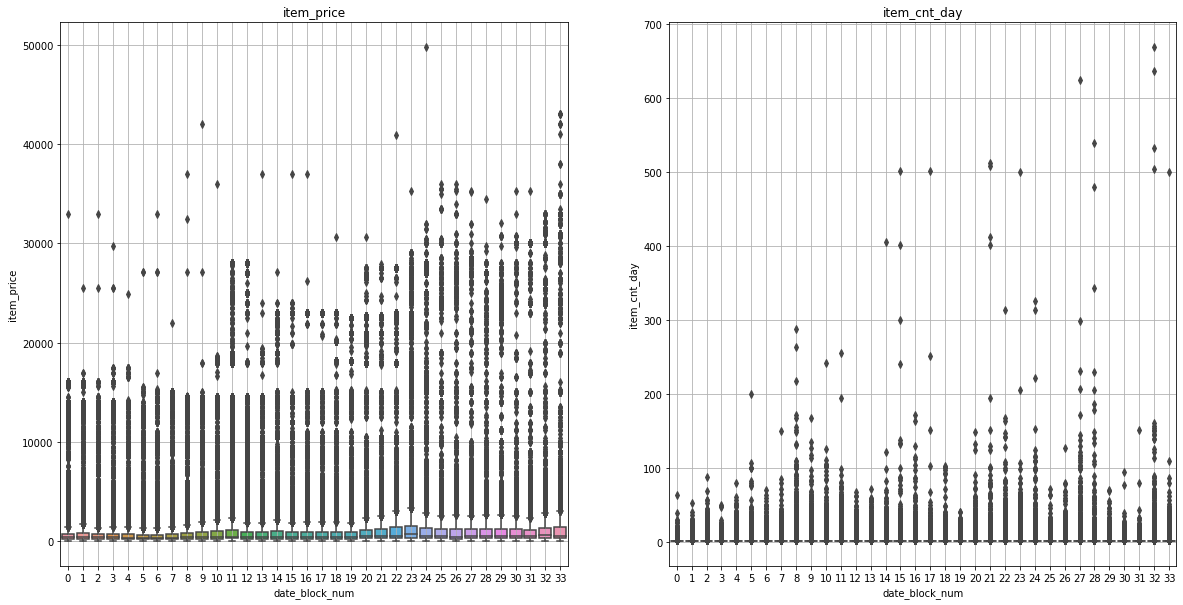

In [8]:
# 제거 후의 boxplot
price_item_cnt_day_boxplot()

In [9]:
train.corr()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019329,0.009472,0.095539,0.010339
shop_id,0.019329,1.000000,0.029345,-0.023955,-0.005660
item_id,0.009472,0.029345,1.000000,-0.134812,0.018896
item_price,0.095539,-0.023955,-0.134812,1.000000,0.014444
item_cnt_day,0.010339,-0.005660,0.018896,0.014444,1.000000


## shops

In [10]:
shops.info() # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [11]:
shops.head(20)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


- 이름에 특수문자가 들어가고 중복되는 이름들이 보인다

In [12]:
def clean_text(inputString):
    text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', inputString)
    return text_rmv
shops_names = shops["shop_name"].apply(clean_text)
shops_id = shops["shop_id"]
# 중복되는 이름 확인 
for i in list(zip(shops_names ,shops_id)):
    for j in list(zip(shops_names ,shops_id)):
        if (re.match('.*'+i[0]+'*.',j[0])) and (i[1]!= j[1]):
            print('code : ', i[1], ' and  ', j[1])
            print('name : ', i[0], ' and  ', j[0])
            

code :  10  and   11
name :  Жуковский ул  Чкалова 39м   and   Жуковский ул  Чкалова 39м²
code :  11  and   10
name :  Жуковский ул  Чкалова 39м²  and   Жуковский ул  Чкалова 39м 
code :  39  and   40
name :  РостовНаДону ТРК  Мегацентр Горизонт   and   РостовНаДону ТРК  Мегацентр Горизонт  Островной
code :  57  and   0
name :  Якутск Орджоникидзе  56  and    Якутск Орджоникидзе  56 фран
code :  58  and   1
name :  Якутск ТЦ  Центральный   and    Якутск ТЦ  Центральный  фран


- 위와 같이 shop id가 10:11, 39:40, 57:0, 58:1 4개의 아이디가 중복되는 것을 알 수 있다.
- 위의 데이터를 기준으로 train data의 shop id를 바꾸어준다

In [13]:
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})

## items

In [14]:
items.info() # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [15]:
items.head(20) # 이름에 특수 문자 제거 후 비슷한 게임끼리 

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


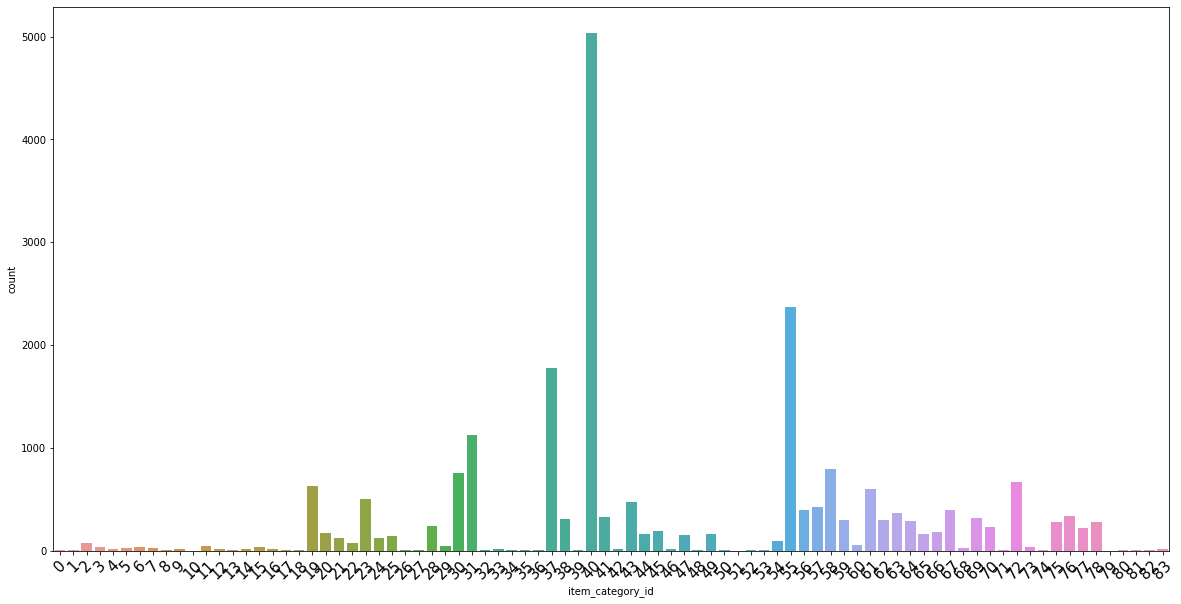

In [16]:
plt.figure(figsize=(20,10))
sns.countplot(x= 'item_category_id' , data = items)
plt.xticks(size = 15 , rotation =  45 , color = 'black')
plt.show()

In [17]:
item_categories[item_categories['item_category_id']==40]

,item_category_name,item_category_id
40,Кино - DVD,40


- item_category_id =40 인  Кино - DVD 카테고리에 많은 아이템이 존재하는지 알 수 있다

## item_category

In [18]:
item_categories.info()  # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [19]:
item_categories.head(20)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


- item_category_name에 같은 단어가 들어가는 데이터가 많이 존재한다
- 이를 묶어 더 큰 범주를 만들 수 있다.

## test

In [20]:
test.info()  # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [21]:
# test의 shop_id , item_id 기 train 데이터에 있는지 확인
diff_test_train_shop_id  = set(test['shop_id']) - set(train['shop_id'])
print('diffrent shop_id nums: ',len(diff_test_train_shop_id))
diff_test_train_item_id = set(test['item_id']) - set(train['item_id'])
print('diffrent item_id nums: ',len(diff_test_train_item_id))
diff_test_items_item_id = set(test['item_id']) - set(items['item_id'])
print('diff_test_items_itemid nums: ',len(diff_test_items_item_id))

diffrent shop_id nums:  0
diffrent item_id nums:  363
diff_test_items_itemid nums:  0


#### test에는 존재하지만 train에 존재하지 않는 값이 363개 존재한다. 
#### items에는 test에 있는 모든 item_id를 가지고 있다. 
#### 이를 해결하기위해 다음과 같은 방법을 사용한다
 - train에 존재하지 않는 test값을 예측하기 위해 item_category_id를 사용한다.

## high_category

item_category의 앞부분만 자르고 새롭게 만든 열을 라벨인코딩 (악세사리 >> 1)   
item_id와 연결되어있는 item_category를 새롭게 만든 열로 연결하여 test값을 예측한다면?

In [22]:
# item_category 분류하여 새로운 열 만들기
def make_high_category(data_name_col):
    '''
    상위 분류를 생성후 라벨 인코딩을 하는 함수
    shopname 과 item_category_name 에 사용
    '''
    data_name_col
    data_name_col = data_name_col.apply(clean_text)
    high_category_name = data_name_col.str.split(' ')
    high_category_name = [data[1] if data[0] == '' else data[0] for data in high_category_name]
    high_category_name_le = LabelEncoder()
    high_category_name_le.fit(high_category_name)
    high_category_id = high_category_name_le.transform(high_category_name)
    return high_category_name , high_category_id

In [23]:
item_categories['high_category_name'] , item_categories['high_category_id'] =\
make_high_category(item_categories.item_category_name)

In [24]:
item_categories.head(3)

,item_category_name,item_category_id,high_category_name,high_category_id
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1


In [25]:
shops['city_name'],shops['city_id'] = make_high_category(shops.shop_name)

In [26]:
shops.head(3)

,shop_name,shop_id,city_name,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0


## train + test 

In [27]:
'''
test에 없는 열을 추가 해야 하거나
train에 쓸모없는 데이터를 제거해야 한다. 
'''
test.columns , train.columns

(Index(['ID', 'shop_id', 'item_id'], dtype='object'),
 Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
        'item_cnt_day'],
       dtype='object'))

In [28]:
test['date_block_num'] = 34
test['item_price'] = 1
test['item_cnt_day'] = 0
del train['date']
del test['ID']

In [29]:
test.columns , train.columns

(Index(['shop_id', 'item_id', 'date_block_num', 'item_price', 'item_cnt_day'], dtype='object'),
 Index(['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'], dtype='object'))

In [30]:
# 인덱스 값이 꼬여있다.
pd.concat([test,train])

,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,5,5037,34,1.0,0.0
1,5,5320,34,1.0,0.0
2,5,5233,34,1.0,0.0
3,5,5232,34,1.0,0.0
4,5,5268,34,1.0,0.0
...,...,...,...,...,...
2935844,25,7409,33,299.0,1.0
2935845,25,7460,33,299.0,1.0
2935846,25,7459,33,349.0,1.0
2935847,25,7440,33,299.0,1.0


In [31]:
pd.concat([test,train]).sort_values('date_block_num').reset_index().drop('index',axis = 1)

,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,16,18336,0,299.0,1.0
1,25,18631,0,149.0,1.0
2,25,19333,0,350.0,1.0
3,25,19330,0,349.0,1.0
4,25,18546,0,149.0,1.0
...,...,...,...,...,...
3142682,57,18454,34,1.0,0.0
3142683,57,18027,34,1.0,0.0
3142684,57,18049,34,1.0,0.0
3142685,57,18589,34,1.0,0.0


In [32]:
sales_df = pd.concat([test,train]).sort_values('date_block_num').reset_index().drop('index',axis = 1)

In [33]:
sales_df = pd.merge(sales_df ,shops ,on =  'shop_id').drop(['shop_name','city_name'] ,axis =1)

In [34]:
sales_df.head(3)

,shop_id,item_id,date_block_num,item_price,item_cnt_day,city_id
0,16,18336,0,299.0,1.0,10
1,16,21347,0,549.0,1.0,10
2,16,20890,0,1899.0,1.0,10


In [35]:
item_high_categories = items.merge(item_categories).drop(['item_name','item_category_name','high_category_name'],axis = 1)
item_high_categories.head(3)

,item_id,item_category_id,high_category_id
0,0,40,7
1,2,40,7
2,3,40,7


In [36]:
sales_df = pd.merge(sales_df ,item_high_categories ,on =  'item_id')

In [37]:
sales_df['item_revenue_day'] = sales_df.item_cnt_day * sales_df.item_price

In [38]:
sales_df.head(3)

,shop_id,item_id,date_block_num,item_price,item_cnt_day,city_id,item_category_id,high_category_id,item_revenue_day
0,16,18336,0,299.0,1.0,10,57,9,299.0
1,25,18336,0,299.0,1.0,13,57,9,299.0
2,25,18336,1,299.0,1.0,13,57,9,299.0


In [39]:
base_item_feature_names = ['item_id','item_category_id','high_category_id']
base_place_feature_names = ['shop_id','city_id']
mean_feature_names = ['item_cnt_day','item_revenue_day']

In [40]:
def add_mean_feature(df , base_feature_names ,mean_feature_names):
    '''
    base_feature_name를 기준으로 mean_feature_names의 값들을 
    한달 평균을 구해서 df에 병합해주는 함수
    '''
    df_pivot  = df[list(base_feature_names) + list(mean_feature_names)]
    col_name = ''
    for base_feature_name in base_feature_names:
        if base_feature_name !='date_block_num':
            col_name += '_'.join(base_feature_name.split('_')[:-1])+'_'

    for mean_feature_name in mean_feature_names:
        df_pivot = df_pivot.rename(columns = {mean_feature_name:col_name + mean_feature_name.split('_')[1]+'_month_mean'})

    df_pivot = df_pivot.pivot_table(index = base_feature_names)
    df = df.merge(df_pivot , on =base_feature_names)
    return df

In [41]:
for place in base_place_feature_names:
    for item in base_item_feature_names:
        base_feature_names = ['date_block_num', place,item]
        sales_df = add_mean_feature(sales_df ,base_feature_names,mean_feature_names)

In [42]:
sales_df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_price', 'item_cnt_day',
       'city_id', 'item_category_id', 'high_category_id', 'item_revenue_day',
       'shop_item_cnt_month_mean', 'shop_item_revenue_month_mean',
       'shop_item_category_cnt_month_mean',
       'shop_item_category_revenue_month_mean',
       'shop_high_category_cnt_month_mean',
       'shop_high_category_revenue_month_mean', 'city_item_cnt_month_mean',
       'city_item_revenue_month_mean', 'city_item_category_cnt_month_mean',
       'city_item_category_revenue_month_mean',
       'city_high_category_cnt_month_mean',
       'city_high_category_revenue_month_mean'],
      dtype='object')

# drop uslessID

In [43]:
sales_df.drop(base_item_feature_names+base_place_feature_names , axis =1  , inplace = True)

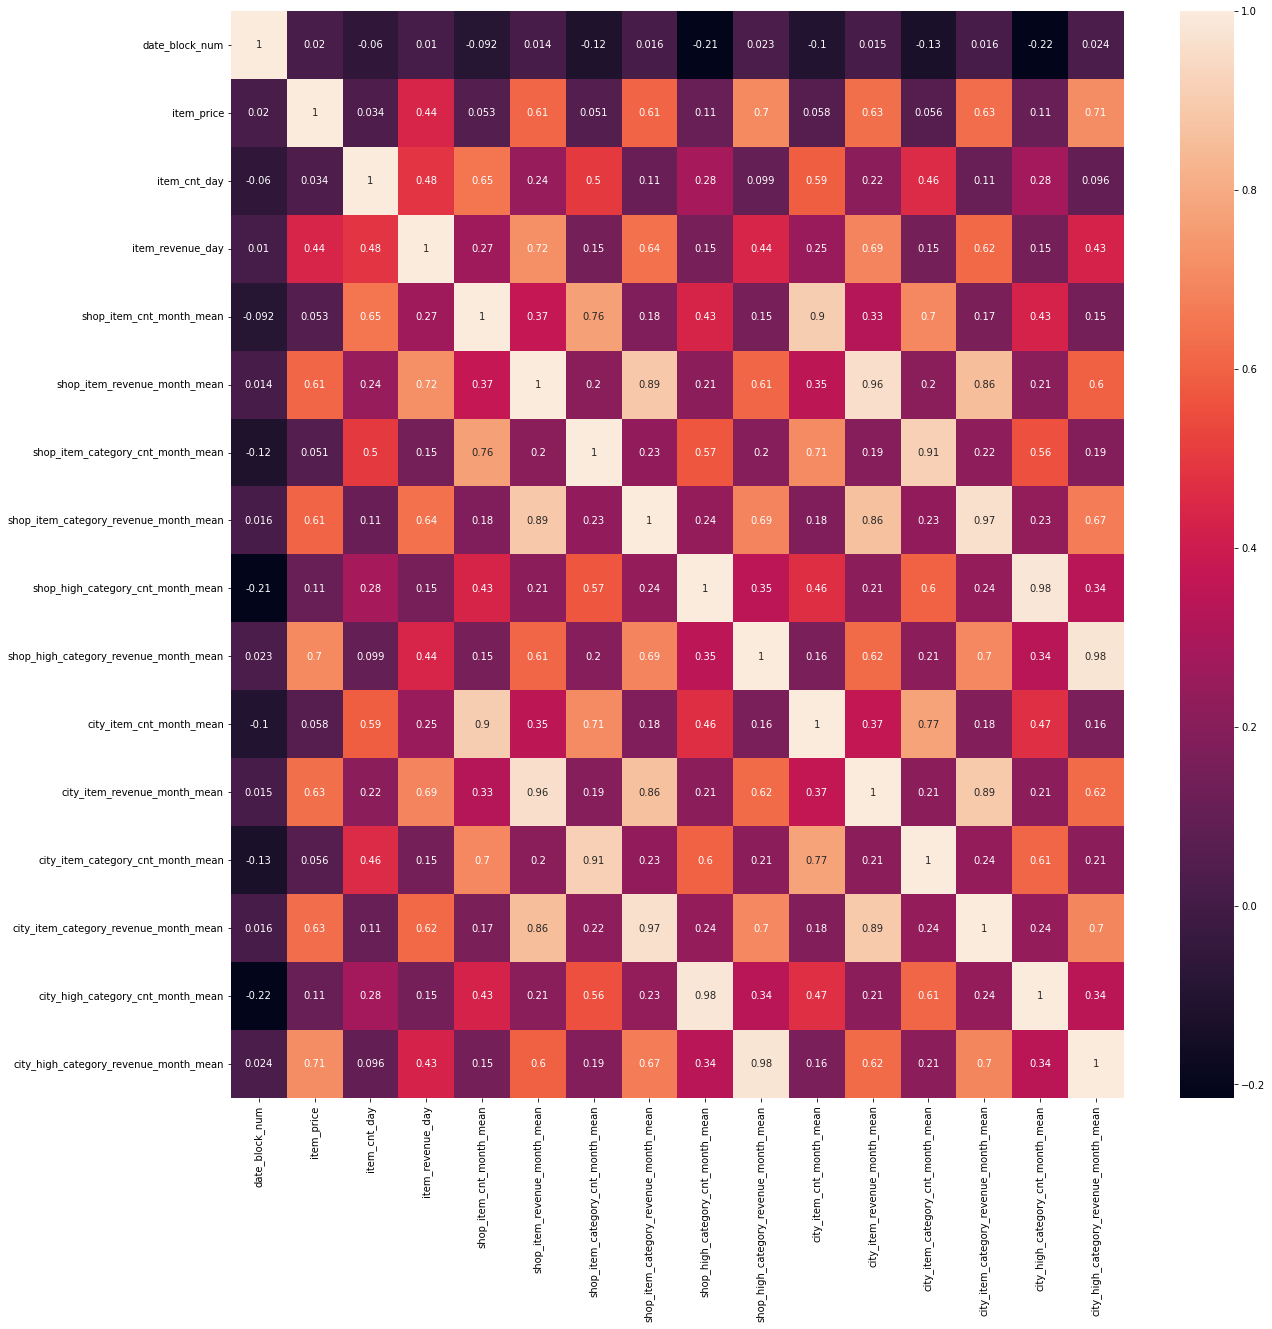

In [44]:
plt.figure(figsize=(20,20))
sns.heatmap(sales_df.corr() , annot=True)
plt.show()

# Holdsout

In [45]:
x_train = sales_df[sales_df['date_block_num'] < 33]
x_train = x_train.drop(['item_cnt_day'], axis = 1)
y_train = sales_df[sales_df['date_block_num'] < 33]['item_cnt_day']


x_valid = sales_df[sales_df['date_block_num'] == 33]
x_valid = x_valid.drop(['item_cnt_day'], axis = 1)
y_valid = sales_df[sales_df['date_block_num'] == 33]['item_cnt_day']

x_test = sales_df[sales_df['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_day'], axis = 1)
y_test = sales_df[sales_df['date_block_num'] == 34]['item_cnt_day']

# acf, pacf

In [46]:
import statsmodels.graphics.tsaplots as sgt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

In [47]:
# fig = plt.figure(figsize=(12,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(sales_df.values.squeeze(), lags=40, ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(sales_df, lags=40, ax=ax2)

In [48]:
sales_df.head()

,date_block_num,item_price,item_cnt_day,item_revenue_day,shop_item_cnt_month_mean,shop_item_revenue_month_mean,shop_item_category_cnt_month_mean,shop_item_category_revenue_month_mean,shop_high_category_cnt_month_mean,shop_high_category_revenue_month_mean,city_item_cnt_month_mean,city_item_revenue_month_mean,city_item_category_cnt_month_mean,city_item_category_revenue_month_mean,city_high_category_cnt_month_mean,city_high_category_revenue_month_mean
0,0,299.0,1.0,299.0,1.0,299.0,1.0,309.95122,1.009901,306.118812,1.0,299.0,1.0,309.95122,1.009901,306.118812
1,0,299.0,1.0,299.0,1.0,299.0,1.0,309.95122,1.009901,306.118812,1.0,299.0,1.0,309.95122,1.009901,306.118812
2,0,299.0,1.0,299.0,1.0,299.0,1.0,309.95122,1.009901,306.118812,1.0,299.0,1.0,309.95122,1.009901,306.118812
3,0,299.0,1.0,299.0,1.0,299.0,1.0,309.95122,1.009901,306.118812,1.0,299.0,1.0,309.95122,1.009901,306.118812
4,0,299.0,1.0,299.0,1.0,299.0,1.0,309.95122,1.009901,306.118812,1.0,299.0,1.0,309.95122,1.009901,306.118812


In [49]:
train2 = pd.read_csv("./data/sales_train.csv")

In [50]:
train2["date"] = pd.to_datetime(train2["date"], format="%d.%m.%Y")

In [51]:
train2.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [52]:
I_am_acf = train2.pivot_table(index = 'date')

In [53]:
hello_acf = I_am_acf.drop(['date_block_num','shop_id','item_id','item_price'], axis = 1)

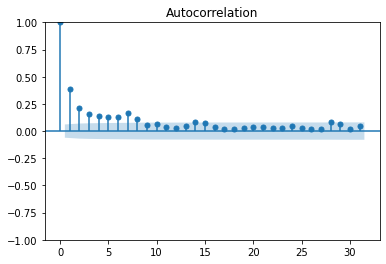

In [54]:
plot_acf(hello_acf['item_cnt_day'])
plt.show()

/Users/lina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


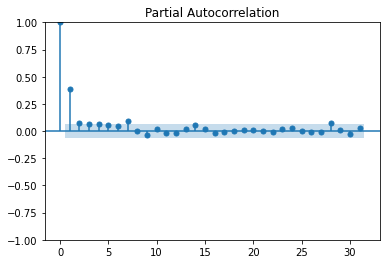

In [55]:
plot_pacf(hello_acf['item_cnt_day'])
plt.show()

In [56]:
sales_df

,date_block_num,item_price,item_cnt_day,item_revenue_day,shop_item_cnt_month_mean,shop_item_revenue_month_mean,shop_item_category_cnt_month_mean,shop_item_category_revenue_month_mean,shop_high_category_cnt_month_mean,shop_high_category_revenue_month_mean,city_item_cnt_month_mean,city_item_revenue_month_mean,city_item_category_cnt_month_mean,city_item_category_revenue_month_mean,city_high_category_cnt_month_mean,city_high_category_revenue_month_mean
0,0,299.0,1.0,299.0,1.000000,299.000000,1.000000,309.951220,1.009901,306.118812,1.000000,299.000000,1.000000,309.951220,1.009901,306.118812
1,0,299.0,1.0,299.0,1.000000,299.000000,1.000000,309.951220,1.009901,306.118812,1.000000,299.000000,1.000000,309.951220,1.009901,306.118812
2,0,299.0,1.0,299.0,1.000000,299.000000,1.000000,309.951220,1.009901,306.118812,1.000000,299.000000,1.000000,309.951220,1.009901,306.118812
3,0,299.0,1.0,299.0,1.000000,299.000000,1.000000,309.951220,1.009901,306.118812,1.000000,299.000000,1.000000,309.951220,1.009901,306.118812
4,0,299.0,1.0,299.0,1.000000,299.000000,1.000000,309.951220,1.009901,306.118812,1.000000,299.000000,1.000000,309.951220,1.009901,306.118812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142682,32,1500.0,5.0,7500.0,56.689655,89489.655172,29.819767,41904.069767,29.819767,41904.069767,56.689655,89489.655172,29.819767,41904.069767,29.819767,41904.069767
3142683,32,1500.0,9.0,13500.0,56.689655,89489.655172,29.819767,41904.069767,29.819767,41904.069767,56.689655,89489.655172,29.819767,41904.069767,29.819767,41904.069767
3142684,32,1500.0,11.0,16500.0,56.689655,89489.655172,29.819767,41904.069767,29.819767,41904.069767,56.689655,89489.655172,29.819767,41904.069767,29.819767,41904.069767
3142685,32,1500.0,12.0,18000.0,56.689655,89489.655172,29.819767,41904.069767,29.819767,41904.069767,56.689655,89489.655172,29.819767,41904.069767,29.819767,41904.069767


In [57]:
# withlag = sales_df.copy()

In [ ]:
# withmooc['sal_lag'] = emp.sort_values(by='hiredate').groupby('job')['sal'].shift(1,fill_value = 0)

# withmooc.sort_values(['job','hiredate']).head(10)

In [ ]:
# emp.sort_values(by='hiredate').groupby('job')['sal'].shift(1,fill_value = 0)

# XGboost

In [47]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [48]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set= [(x_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 150)

/Users/lina/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/lina/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:2.58481
[1]	validation_0-rmse:2.37898
[2]	validation_0-rmse:2.25101
[3]	validation_0-rmse:2.15849
[4]	validation_0-rmse:2.09192
[5]	validation_0-rmse:2.04223
[6]	validation_0-rmse:2.01233
[7]	validation_0-rmse:1.99713
[8]	validation_0-rmse:1.97904
[9]	validation_0-rmse:1.98403
[10]	validation_0-rmse:1.95846
[11]	validation_0-rmse:1.96286
[12]	validation_0-rmse:1.94809
[13]	validation_0-rmse:1.95891
[14]	validation_0-rmse:1.95423
[15]	validation_0-rmse:1.93872
[16]	validation_0-rmse:1.95046
[17]	validation_0-rmse:1.93713
[18]	validation_0-rmse:1.94466
[19]	validation_0-rmse:1.93081
[20]	validation_0-rmse:1.94466
[21]	validation_0-rmse:1.93047
[22]	validation_0-rmse:1.92259
[23]	validation_0-rmse:1.93333
[24]	validation_0-rmse:1.93051
[25]	validation_0-rmse:1.92101
[26]	validation_0-rmse:1.92243
[27]	validation_0-rmse:1.92475
[28]	validation_0-rmse:1.91421
[29]	validation_0-rmse:1.90878
[30]	validation_0-rmse:1.91724
[31]	validation_0-rmse:1.90668
[32]	validation_0-

[260]	validation_0-rmse:1.75797
[261]	validation_0-rmse:1.75556
[262]	validation_0-rmse:1.75588
[263]	validation_0-rmse:1.75506
[264]	validation_0-rmse:1.75436
[265]	validation_0-rmse:1.75327
[266]	validation_0-rmse:1.75005
[267]	validation_0-rmse:1.75063
[268]	validation_0-rmse:1.74891
[269]	validation_0-rmse:1.74699
[270]	validation_0-rmse:1.74734
[271]	validation_0-rmse:1.74804
[272]	validation_0-rmse:1.74770
[273]	validation_0-rmse:1.74888
[274]	validation_0-rmse:1.74904
[275]	validation_0-rmse:1.75068
[276]	validation_0-rmse:1.75176
[277]	validation_0-rmse:1.74954
[278]	validation_0-rmse:1.74719
[279]	validation_0-rmse:1.74699
[280]	validation_0-rmse:1.75071
[281]	validation_0-rmse:1.74892
[282]	validation_0-rmse:1.75148
[283]	validation_0-rmse:1.75339
[284]	validation_0-rmse:1.75100
[285]	validation_0-rmse:1.75141
[286]	validation_0-rmse:1.74893
[287]	validation_0-rmse:1.74889
[288]	validation_0-rmse:1.74977
[289]	validation_0-rmse:1.74989
[290]	validation_0-rmse:1.74057
[291]	va

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import r2_score
y_predict = model.predict(x_valid)
r2_score(y_valid, y_predict)

# 다시 한번 시작해볼까?

In [58]:
re_train = pd.read_csv("./data/sales_train.csv")
re_test = pd.read_csv("./data/test.csv")

In [59]:
re_test.drop('ID',axis = 1,inplace=True)

In [60]:
re_test

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757
214198,45,19648


In [61]:
re_train.drop(['date','date_block_num','item_price','item_cnt_day'],axis = 1,inplace=True)

In [62]:
re_train

,shop_id,item_id
0,59,22154
1,25,2552
2,25,2552
3,25,2554
4,25,2555
...,...,...
2935844,25,7409
2935845,25,7460
2935846,25,7459
2935847,25,7440


In [63]:
test_train = pd.concat([re_test,re_train], ignore_index=True)

In [64]:
test_train['item_id'].unique()

array([5037, 5320, 5233, ..., 7610, 7635, 7640])

In [65]:
test_train['item_id'].nunique()

22170

In [66]:
test_train['shop_id'].unique()

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45, 23, 27, 29,  0,  1,  8, 13, 30, 32,
       54, 43, 51, 17,  9, 40, 33, 20, 11])

In [67]:
test_train['shop_id'].nunique()

60

In [68]:
test_train

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
3150044,25,7409
3150045,25,7460
3150046,25,7459
3150047,25,7440


In [78]:
test_train_howmuch = test_train.drop_duplicates()   

In [79]:
test_train_howmuch

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
3149870,25,7904
3150002,25,7583
3150004,25,7610
3150011,25,7635


In [77]:
# 데이터프레임 인덱스가 0~34까지의 집을 만들어서  뽀문을 사용해서 넣어두면 되요 넘블럭

In [82]:
index = pd.DataFrame(index = range(0,35))

In [85]:
# Time series decomposition 
# additive model: trend + cycle + seasonality + irregular factor

In [90]:
train2

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [94]:
train2_dt = train2.date
result = seasonal_decompose(train2_dt, model='additive')

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
# ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
# 값 오류: 마침표를 지정해야 합니다. 또는 x는 마침표가 있는 판다 개체여야 합니다.색인 또는 날짜/시간색인

In [101]:
# 시계열 데이터(Time series data)는 시간에 측정되는 값들의 집합이며 센서, 시스템 등에서 끝없이 데이터가 만들어집니다. 
# 시계열 데이터는 모든 곳에서 관측되고 활용되며, 다양한 곳에서 중요한 지표가 됩니다. 
# 시간의 흐름에 따라 과거의 패턴을 분석하여 미래를 예측하는 방법 중에 시계열 분해 방법이 활용되며, 
# 그 4가지 구성 요소 (추세 trend, 순환 cycle, 계절 seasonal, 불규칙 random/residual)에 대해서 알아보겠습니다. 

# (1) 추세 요소 (Trend)는 데이터가 장기적인 측면에서, 증가하거나 감소하는 모양새를 의미합니다.
# (2) 순환 요소 (Cycle)는 경제활동의 팽창과 위축 등과 같이 불규칙적이며 반복적인 장기적인 변화현상을 의미합니다. 정치적, 경제적, 사회적 요인 등으로 인해 이뤄지며 급격한 변화가 없다면 지속되는 특징이 있습니다.
# (3) 계절 요소 (Seasonal)는 주, 월, 분기, 반기, 12개월(1년) 등 특정 주기로 반복되는 특징를 의미하며, 계절의 변화, 시간의 흐름 등과 같은 요소들에 의해 시간에 따른 특징이 나타납니다.
# (4) 불규칙 요소 (Random/Residual)는 일정한 규칙성을 인지할 수 없는 변동의 유형을 의미합니다. 시계열 분해법에서는 원래 데이터에서 추세, 순환, 계절성을 뺀 나머지 불규칙 요소로 합니다.
# 시계열 분해 방식은 구성요소 간의 결합 방식에 따라서 (1) 각 요소가 독립적으로 작용하여, 이를 분해해서 특징을 확인하는 덧셈 분해 (Additive Decomposition)과, (2) 각 요소가 서로 상호작용하여, 이를 분해해서 특징을 확인하는 곱셈 분해 (Multiplicative Decomposition)로 구분할 수 있습니다. 

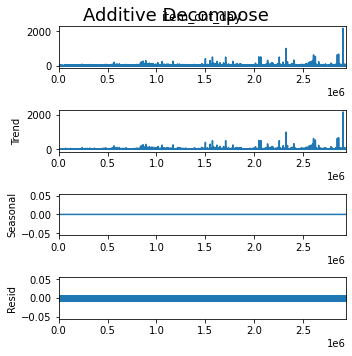

In [130]:
result_add = seasonal_decompose(x=train2['item_cnt_day'], model='additive', extrapolate_trend='freq', period=1)
plt.rcParams.update({'figure.figsize': (5,5)})
result_add.plot().suptitle('Additive Decompose', fontsize=18)
plt.show()

In [119]:
# timestamp = np.arange(len(train2['item_cnt_day']))

In [120]:
# trend_factor = timestamp * 1.2

In [116]:
# cycle_factor = 10 * np.sin(np.linspace(0, 3.14 * 2, 48))
# seasonal_factor = 7 * np.sin(np.linspace(0, 3.14 * 8, 48))
# np.random.seed(10)
# residual_factor = 2 * np.random.randn(len(train2['item_cnt_day']))

In [121]:
# df = pd.DataFrame({'timeseries' : trend_factor + cycle_factor + seasonal_factor + residual_factor,
#                    'trend' : trend_factor,
#                    'cycle' : cycle_factor,
#                    'seasonal' : seasonal_factor,
#                    'residual' : residual_factor}, index=train2)

# real time series decomposition

In [132]:
sales_train = pd.read_csv("./data/sales_train.csv")

In [134]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [140]:
# Convert the date column to a datetime type
sales_train['date'] = sales_train['date'].apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

NameError: name 'datetime' is not defined

In [141]:
sales_train['date'] = pd.to_datetime(sales_train["date"], format="%d.%m.%Y")

In [143]:
sales_train['month'] = sales_train['date'].dt.to_period('M')
sales_train['month'] = sales_train['month'].astype(str)
sales_train_mon=sales_train.copy()

In [144]:
sales_train['month'] = pd.to_datetime(sales_train['month'])

In [145]:
sales_train_gb = sales_train.groupby(['month']).agg({'item_cnt_day':'sum'})

In [146]:
sales_train_gb

,item_cnt_day
month,
2013-01-01,131479.0
2013-02-01,128090.0
2013-03-01,147142.0
2013-04-01,107190.0
2013-05-01,106970.0
2013-06-01,125381.0
2013-07-01,116966.0
2013-08-01,125291.0
2013-09-01,133332.0


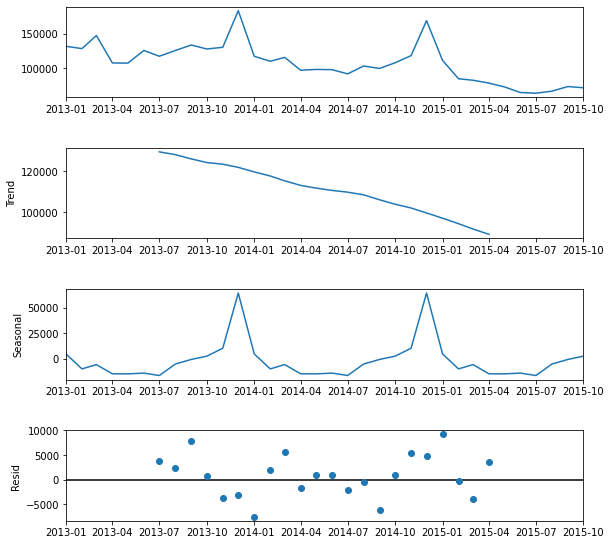

In [147]:
# seasonal_decompose for additive model
seasonal_decompose(sales_train_gb, model = 'additive').plot().set_size_inches(10, 8)

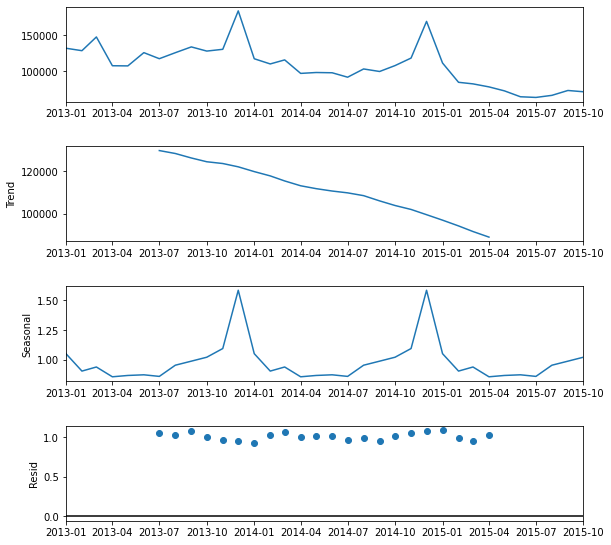

In [148]:
# seasonal_decompose for multiplicative model
seasonal_decompose(sales_train_gb, model = 'multiplicative').plot().set_size_inches(10, 8)